# Face Mask Detection

---
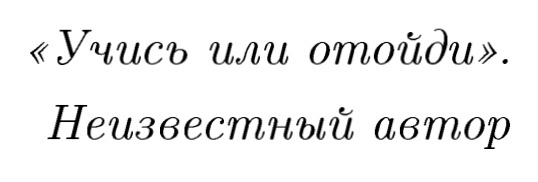

**What did I use?** 
OpenCV and MTCNN for object detection, CNN with TensorFlow and Keras for making prediction and a lot of enthusiasm.

**Dataset**: https://www.kaggle.com/wobotintelligence/face-mask-detection-dataset/

# Imports

In [2]:
! pip install mtcnn

     |████████████████████████████████| 2.3MB 9.7MB/s 


In [3]:
from mtcnn import MTCNN
import cv2
import numpy as np 
import pandas as pd 
import os
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import tensorflow as tf
from keras.layers import Flatten, Dense, Conv2D, MaxPooling2D, Dropout
from keras.models import Sequential
from keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder

# Loading Dataset

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
PATH_TO_DATASET_IMAGES = '/content/drive/My Drive/face-mask-detection-dataset/Medical mask/Medical mask/Medical Mask/'
PATH_TO_DATASET_CSV = '/content/drive/My Drive/face-mask-detection-dataset/'

In [ ]:
images=os.path.join(PATH_TO_DATASET_IMAGES + 'images')

annotations=os.path.join(PATH_TO_DATASET_IMAGES + 'annotations')

train=pd.read_csv(os.path.join(PATH_TO_DATASET_CSV + 'train.csv'))

submission=pd.read_csv(os.path.join(PATH_TO_DATASET_CSV + 'submission.csv'))

In [ ]:
train.head(5)

,name,x1,x2,y1,y2,classname
0,2756.png,69,126,294,392,face_with_mask
1,2756.png,505,10,723,283,face_with_mask
2,2756.png,75,252,264,390,mask_colorful
3,2756.png,521,136,711,277,mask_colorful
4,6098.jpg,360,85,728,653,face_no_mask


In [ ]:
a = os.listdir(images)
b = os.listdir(annotations)
a.sort()
b.sort()
print(len(b),len(a))

4386 6024


In [ ]:
train_images = a[1698:]
test_images = a[:1698]

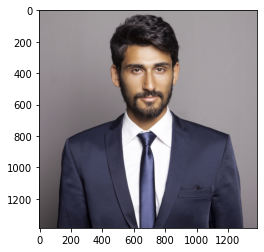

In [ ]:
img = plt.imread(os.path.join(images, train_images[0]))
plt.imshow(img)
plt.show()

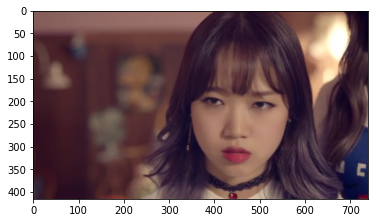

In [ ]:
img = plt.imread(os.path.join(images, test_images[1]))
plt.imshow(img)
plt.show()

In [ ]:
options = ['face_with_mask', 'face_no_mask']
train = train[train['classname'].isin(options)]
train.sort_values('name', axis=0, inplace=True)

In [ ]:
def get_boxes(id):
    boxes = []
    for i in train[train["name"]==str(id)]["bbox"]:
        boxes.append(i)
    return boxes

[[435, 83, 583, 276]]


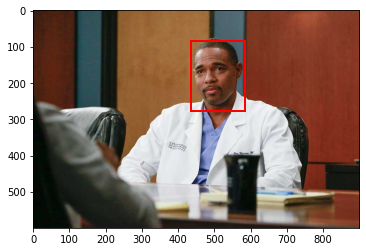

In [ ]:
bbox = []

for i in range(len(train)):
    arr = []
    for j in train.iloc[i][["x1",'x2','y1','y2']]:
        arr.append(j)
    bbox.append(arr)
train["bbox"] = bbox  

print(get_boxes(train_images[10]))
image = train_images[10]

img = plt.imread(os.path.join(images,image))

fig,ax = plt.subplots(1)
ax.imshow(img)

boxes = get_boxes(image)

for box in boxes:
    rect = patches.Rectangle((box[0], box[1]), box[2]-box[0], box[3]-box[1], linewidth=2, edgecolor='r', facecolor='none')
    ax.add_patch(rect)

plt.show()

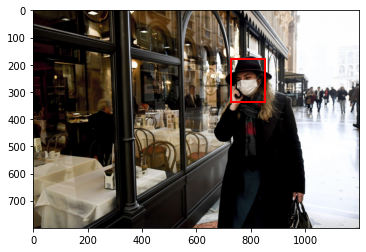

In [ ]:
image=train_images[4]

img=plt.imread(os.path.join(images,image))

fig,ax = plt.subplots(1)
ax.imshow(img)
boxes = get_boxes(image)
for box in boxes:
    rect = patches.Rectangle((box[0],box[1]), box[2]-box[0], box[3]-box[1], linewidth=2, edgecolor='r', facecolor='none')
    ax.add_patch(rect)
plt.show()

# Training Dataset

In [ ]:
img_size = 50
data = []

path = PATH_TO_DATASET_IMAGES + 'images'

def create_data():
       for i in range(len(train)):
            arr=[]
            for j in train.iloc[i]:
                   arr.append(j)
            print(arr)
            img_array=cv2.imread(os.path.join(images,arr[0]),cv2.IMREAD_GRAYSCALE)
            crop_image = img_array[arr[2]:arr[4], arr[1]:arr[3]]
            new_img_array=cv2.resize(crop_image,(img_size,img_size))
            data.append([new_img_array,arr[5]])
create_data()  

Streaming output truncated to the last 5000 lines.
['2362.png', 3, 171, 145, 338, 'face_with_mask', [3, 171, 145, 338]]
['2362.png', 222, 115, 339, 275, 'face_with_mask', [222, 115, 339, 275]]
['2363.png', 147, 207, 281, 366, 'face_with_mask', [147, 207, 281, 366]]
['2365.png', 430, 38, 535, 201, 'face_with_mask', [430, 38, 535, 201]]
['2365.png', 713, 71, 796, 184, 'face_with_mask', [713, 71, 796, 184]]
['2366.png', 321, 111, 450, 257, 'face_with_mask', [321, 111, 450, 257]]
['2367.png', 215, 48, 316, 204, 'face_with_mask', [215, 48, 316, 204]]
['2368.png', 239, 146, 349, 301, 'face_with_mask', [239, 146, 349, 301]]
['2369.png', 566, 9, 791, 286, 'face_with_mask', [566, 9, 791, 286]]
['2371.png', 432, 382, 473, 435, 'face_with_mask', [432, 382, 473, 435]]
['2371.png', 238, 364, 303, 431, 'face_with_mask', [238, 364, 303, 431]]
['2371.png', 606, 335, 679, 410, 'face_with_mask', [606, 335, 679, 410]]
['2371.png', 449, 348, 479, 377, 'face_no_mask', [449, 348, 479, 377]]
['2372.png', 287

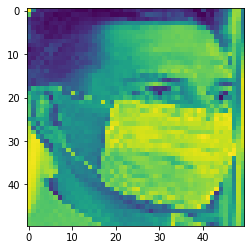

In [ ]:
plt.imshow(data[1][0])

In [ ]:
x, y = [], []

for features, labels in data:
    x.append(features)
    y.append(labels)

lbl = LabelEncoder()
y = lbl.fit_transform(y)

In [ ]:
x = np.array(x).reshape(-1, 50, 50, 1)
x = tf.keras.utils.normalize(x, axis=1)

y = to_categorical(y)

# Model

In [ ]:
model = Sequential()

model.add(Conv2D(100, (3,3), 
                input_shape=x.shape[1:], 
                activation='relu', 
                strides=2))

model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Conv2D(64, (3,3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Flatten())
model.add(Dense(50, activation='relu'))
model.add(Dropout(0.2))

model.add(Dense(2, activation='softmax'))

In [ ]:
checkpoint_path = "training/cp.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)

cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_weights_only=True,
                                                 verbose=1)

In [ ]:
opt = tf.keras.optimizers.Adam(lr=1e-3, decay=1e-5)

model.compile(optimizer=opt, 
              loss='categorical_crossentropy', 
              metrics=['accuracy'],
              ) 

model.fit(x, y,
          epochs=30,
          batch_size=4)

Epoch 1/30
1438/1438 [==============================] - 13s 9ms/step - loss: 0.5936 - accuracy: 0.7247
Epoch 2/30
1438/1438 [==============================] - 12s 9ms/step - loss: 0.4879 - accuracy: 0.7225
Epoch 3/30
1438/1438 [==============================] - 12s 8ms/step - loss: 0.4420 - accuracy: 0.7957
Epoch 4/30
1438/1438 [==============================] - 12s 8ms/step - loss: 0.3952 - accuracy: 0.8196
Epoch 5/30
1438/1438 [==============================] - 13s 9ms/step - loss: 0.3474 - accuracy: 0.8544
Epoch 6/30
1438/1438 [==============================] - 12s 9ms/step - loss: 0.3217 - accuracy: 0.8570
Epoch 7/30
1438/1438 [==============================] - 13s 9ms/step - loss: 0.2867 - accuracy: 0.8789
Epoch 8/30
1438/1438 [==============================] - 13s 9ms/step - loss: 0.2721 - accuracy: 0.8844
Epoch 9/30
1438/1438 [==============================] - 13s 9ms/step - loss: 0.2440 - accuracy: 0.9017
Epoch 10/30
1438/1438 [==============================] - 13s 9ms/step - l

# Saving Model

In [ ]:
model.save('/content/drive/My Drive/saved_model_h2/fmd_model')

INFO:tensorflow:Assets written to: /content/drive/My Drive/saved_model_h2/fmd_model/assets


# Testing Model

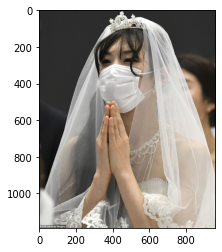

In [ ]:
detector = MTCNN()

img = plt.imread(os.path.join(images, test_images[389]))
faces = detector.detect_faces(img)
test = []
for face in faces:
    bounding_box = face['box']
    test.append([test_images[389], bounding_box])
plt.imshow(img)

In [ ]:
test_data=[]
def create_test_data():
    for j in test:
        img = cv2.imread(os.path.join(images, j[0]), cv2.IMREAD_GRAYSCALE)
        img = img[j[1][1]:j[1][1]+j[1][3], j[1][0]:j[1][0]+j[1][2]]

        new_img = cv2.resize(img, (50, 50))
        new_img = new_img.reshape(-1, 50, 50, 1)
        predict = model.predict(new_img)
        (without_mask, with_mask) = model.predict(new_img)[0]
        print(without_mask)
        print(with_mask)
        test_data.append([j, predict])

create_test_data()      


0.0
1.0


In [ ]:
from google.colab.patches import cv2_imshow

face_with_mask


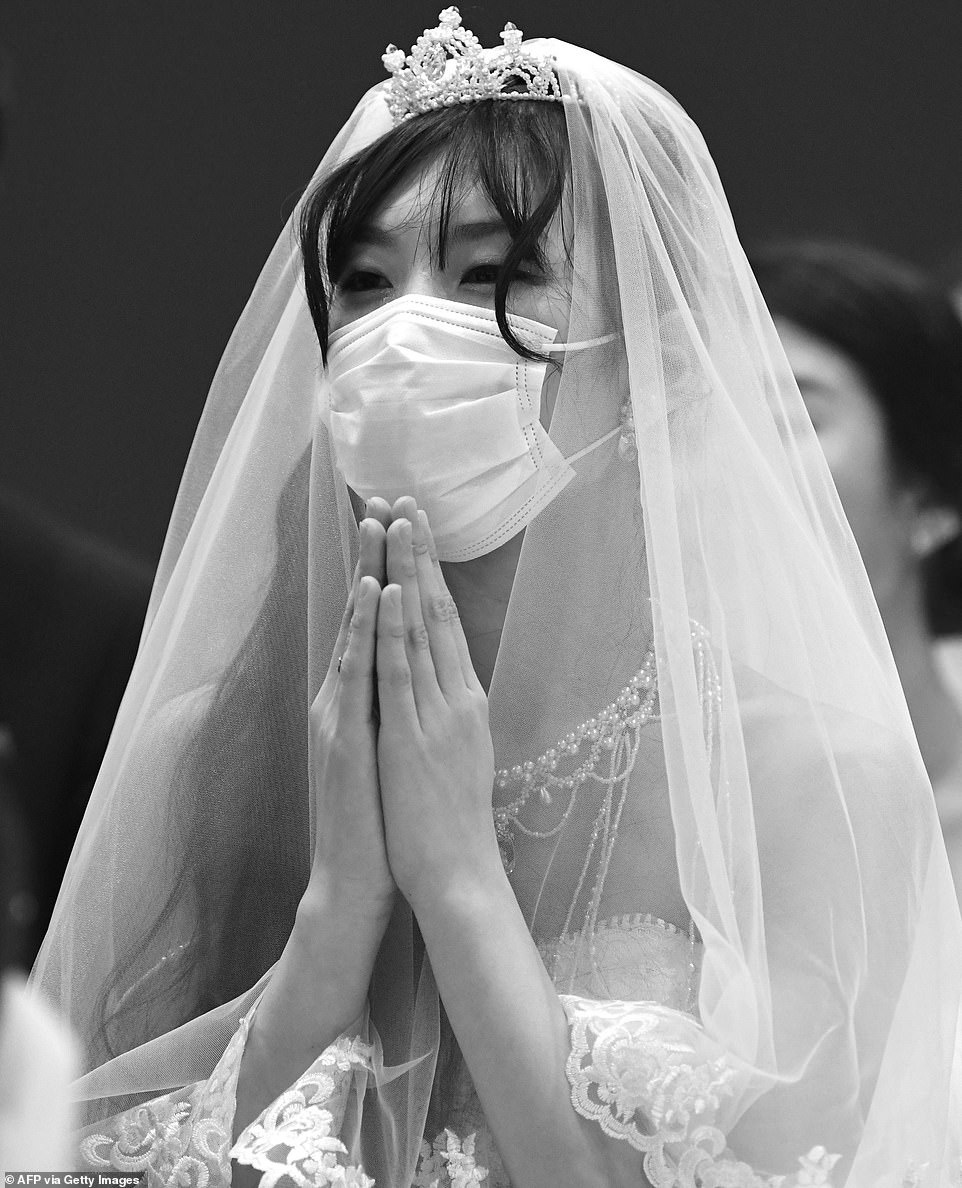

In [ ]:
for i, j in test_data:
    (without_mask, with_mask) = j[0]
    image = cv2.imread(os.path.join(images, i[0]), cv2.IMREAD_GRAYSCALE)
    label = "face_with_mask" if with_mask > without_mask else "face_without_mask"
    color = (0, 255, 0) if label == "face_with_mask" else (0, 0, 255)
    boxes = get_boxes(image)
    for box in boxes:
      cv2.rectangle(image, (box[0], box[1]), (box[2]-box[0], box[3]-box[1]), color, 2)
    RGB_img = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    print(label)
    cv2_imshow(RGB_img)

# Loading Saved Model

In [6]:
model = tf.keras.models.load_model('/content/drive/My Drive/saved_model_final/fmd_model')

In [7]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 24, 24, 100)       1000      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 12, 12, 100)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 10, 10, 64)        57664     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 5, 5, 64)          0         
_________________________________________________________________
flatten (Flatten)            (None, 1600)              0         
_________________________________________________________________
dense (Dense)                (None, 50)                80050     
_________________________________________________________________
dropout (Dropout)            (None, 50)                0

Unfortunately, I didn't have enough time for finding more images and writing a more accurate predictive model. And this affected the quality of the prediction :( 
But it was amazing process, I hope next time I'll create something more awesome 😊 